<a href="https://colab.research.google.com/github/sibam23/intro-git/blob/master/Memes_VS_Notes_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random


importing required libraries

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


importing data drom drive

In [3]:
data_meme = "/content/gdrive/My Drive/Stage_0/Stage_0/Memes"
data_note = "/content/gdrive/My Drive/Stage_0/Stage_0/Notes"

In [4]:
def dataloader(folder):
  images = []
  for file in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,file))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(100,100))
    images.append(img)
    
  return images
    

function to label memes as 1,notes as 0

In [5]:
memes = dataloader(data_meme)
notes = dataloader(data_note)
memes = np.array(memes)
memes = memes.reshape(800,3,100,100)
memelabel = np.ones(memes.shape[0])
notes = np.array(notes)
notes = notes.reshape(800,3,100,100)
notelabel = np.zeros(notes.shape[0])
print(notelabel.shape)

                          

(800,)


In [35]:
memedata = list(zip(memes,memelabel))
notedata = list(zip(notes,notelabel))
datatrain = []
datatrain = memedata[0:750] + notedata[0:750]
random.shuffle(datatrain)
X_train,Y_train = list(zip(*datatrain))

datatest = []
datatest = memedata[750:775] + notedata[750:775]
random.shuffle(datatest)
X_test,Y_test = list(zip(*datatest))

dataval = []
dataval = memedata[775:] + notedata[775:]
random.shuffle(dataval)
X_val,Y_val = list(zip(*dataval))

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
X_val = torch.tensor(X_val)
Y_train = torch.tensor(Y_train).long()
Y_test = torch.tensor(Y_test).long()
Y_val = torch.tensor(Y_val).long()
X_train = torch.true_divide(X_train,255.0)
X_test = torch.true_divide(X_test,255.0)
X_val = torch.true_divide(X_val,255.0)




splitting data and converting to tensor

In [46]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,32,5,stride=1)
    self.conv2 = nn.Conv2d(32,48,5,stride=1)
    self.mpool1 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(48,64,5,stride=1)
    self.conv4 = nn.Conv2d(64,96,5)
    self.mpool2 = nn.MaxPool2d(2,2)
    self.conv5 = nn.Conv2d(96,120,11,stride=4)
    self.fc1 = nn.Linear(120*3*3,250)
    self.fc2 = nn.Linear(250,2)
    

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.mpool1(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.mpool2(x)
    x= F.relu(self.conv5(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x




    














network architecture and forward propagation


In [47]:
net = ConvNet()
print(net)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (mpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1))
  (mpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(96, 120, kernel_size=(11, 11), stride=(4, 4))
  (fc1): Linear(in_features=1080, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=2, bias=True)
)


In [48]:

optimizer = torch.optim.Adam(net.parameters(),lr=0.0001)
lossfn = nn.CrossEntropyLoss()

loss function and optimiser(adam)

In [49]:

def accuracy(label, pred):
  pred = F.softmax(pred, dim=1)
  count =0
  pred = torch.argmax(pred, dim=1, keepdims=True)
  pred = pred.reshape(pred.shape[0])
  for i in range(len(label)):
    if label[i]==pred[i]:
      count+=1

  accu = 100*count/label.shape[0]
  return accu

accuracy function

In [50]:
testacc = []
trainloss = []
testloss = []
valacc = []
valloss = []
epoch = 5
for i in range(epoch):
    k=0  
    for j in range(30): 
      
      out = net.forward(X_train[k:k+50])
      loss = lossfn(out, Y_train[k:k+50])
        
      k+=50
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    with torch.no_grad():

      tracc = accuracy(Y_train, net.forward(X_train))
      vloss = lossfn(net.forward(X_val),Y_val)
      tacc = accuracy(Y_test, net.forward(X_test))
      vacc = accuracy(Y_val,net.forward(X_val))

    
    print(f"training loss:{loss}")
    trainloss.append(loss)
    print(f"validation loss:{vloss}")
    valloss.append(vloss.item())
    print(f"training accuracy:{tracc}")
    trainacc.append(tracc)
    print(f"validation accuracy:{vacc}")
    valacc.append(vacc)
    print(f"testing accuracy:{tacc}")
    testacc.append(tacc)
    print()




training loss:0.026904836297035217
validation loss:0.20261606574058533
training accuracy:94.6
validation accuracy:92.0
testing accuracy:96.0

training loss:0.10891931504011154
validation loss:0.1627635508775711
training accuracy:94.66666666666667
validation accuracy:94.0
testing accuracy:96.0

training loss:0.030582383275032043
validation loss:0.14469464123249054
training accuracy:96.53333333333333
validation accuracy:94.0
testing accuracy:96.0

training loss:0.03730110824108124
validation loss:0.13049747049808502
training accuracy:96.53333333333333
validation accuracy:96.0
testing accuracy:98.0

training loss:0.028783848509192467
validation loss:0.14352208375930786
training accuracy:96.86666666666666
validation accuracy:96.0
testing accuracy:98.0



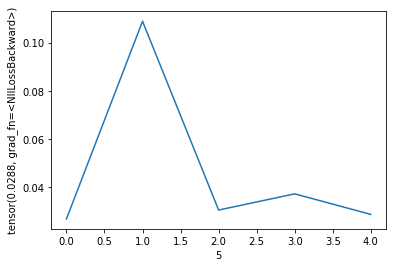

In [52]:
plt.plot(trainloss)
plt.ylabel(loss)
plt.xlabel(epoch)
plt.show()

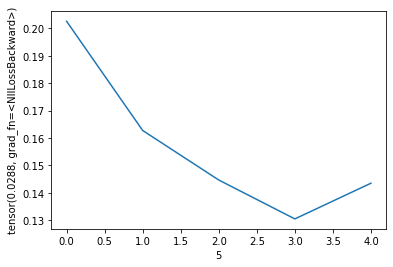

In [53]:
plt.plot(valloss)
plt.ylabel(loss)
plt.xlabel(epoch)
plt.show()